In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

<ipython-input-15-377480755519>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_sequences = np.array(tokenizer.texts_to_sequences(mpermanent['clean_sentences']))


Epoch 1/15
138/138 [==============================] - 22s 123ms/step - loss: 0.6015 - accuracy: 0.8325 - val_loss: 0.5118 - val_accuracy: 0.8392
Epoch 2/15
138/138 [==============================] - 15s 107ms/step - loss: 0.4440 - accuracy: 0.8575 - val_loss: 0.4784 - val_accuracy: 0.8440
Epoch 3/15
138/138 [==============================] - 15s 109ms/step - loss: 0.3349 - accuracy: 0.8817 - val_loss: 0.5110 - val_accuracy: 0.8403
Epoch 4/15
138/138 [==============================] - 14s 98ms/step - loss: 0.2713 - accuracy: 0.9020 - val_loss: 0.6122 - val_accuracy: 0.8254
Epoch 5/15
138/138 [==============================] - 14s 104ms/step - loss: 0.2438 - accuracy: 0.9122 - val_loss: 0.6918 - val_accuracy: 0.7907
Epoch 6/15
138/138 [==============================] - 15s 108ms/step - loss: 0.2043 - accuracy: 0.9295 - val_loss: 0.7245 - val_accuracy: 0.8143
Epoch 7/15
138/138 [==============================] - 15s 106ms/step - loss: 0.1677 - accuracy: 0.9437 - val_loss: 0.6969 - val_acc

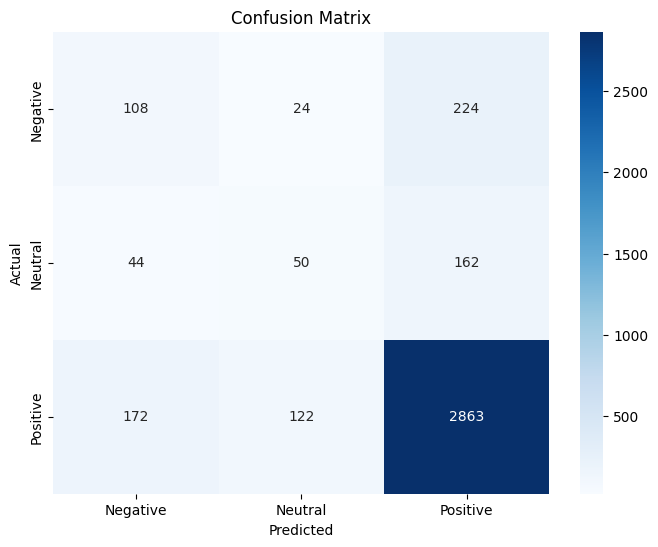

In [ ]:
import numpy as np
import pandas as pd
import string
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Read the dataset
data = pd.read_csv("/content/drive/My Drive/fix_data_preprocesing.csv")

# Extract relevant columns
mpermanent = data[['Review', 'Hasil Perbandingan']]  # Assuming 'Hasil Perbandingan' contains 'Positive', 'Negative', 'Neutral'

# Process the text data
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word.lower() for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Apply text processing to the 'Review' column
mpermanent['clean_review'] = mpermanent['Review'].apply(text_process)

# Join the processed words into sentences
mpermanent['clean_sentences'] = mpermanent['clean_review'].apply(lambda x: ' '.join(x))

# Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(mpermanent['clean_sentences'])
text_sequences = np.array(tokenizer.texts_to_sequences(mpermanent['clean_sentences']))
sequence_dict = tokenizer.word_index

# Encode labels
labels = mpermanent['Hasil Perbandingan']
label_mapping = {'Positive': 2, 'Negative': 0, 'Neutral': 1}  # Mapping labels to integers
Y = np.array([label_mapping[label] for label in labels])

# Pad sequences
max_cap = 20
X = pad_sequences(text_sequences, maxlen=max_cap)

# Split the data into train, dev, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

# Build the LSTM model
embedding_dim = 50
model = Sequential()
model.add(Embedding(len(sequence_dict) + 1, embedding_dim, input_length=max_cap))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=15, validation_data=(X_test, y_test))

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Display actual vs predicted results
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results_df['Actual_Label'] = results_df['Actual'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})
results_df['Predicted_Label'] = results_df['Predicted'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Display counts of actual classes and predicted classes
actual_counts = results_df['Actual_Label'].value_counts()
predicted_counts = results_df['Predicted_Label'].value_counts()

# Display sum of actual and predicted data based on its class
print("\nSum of Actual Data Based on Class:")
print(actual_counts)

print("\nSum of Predicted Data Based on Class:")
print(predicted_counts)

# Display final accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Accuracy: {accuracy * 100:.2f}%")

# Display confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
